Imports

In [16]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

from medpy.metric import binary
from tqdm import tqdm

from monai.apps import CrossValidation, DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

In [17]:
directory = "/datasets/"

In [18]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

Load dataset ready for 5-fold cross validation

In [19]:
cvdataset = CrossValidation(
    dataset_cls=DecathlonDataset,
    nfolds=5,
    seed=0,
    root_dir=directory,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

train_dataset = cvdataset.get_dataset(folds=[1,2,3,4])
val_dataset = cvdataset.get_dataset(folds=0, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

image shape: torch.Size([4, 240, 240, 155])


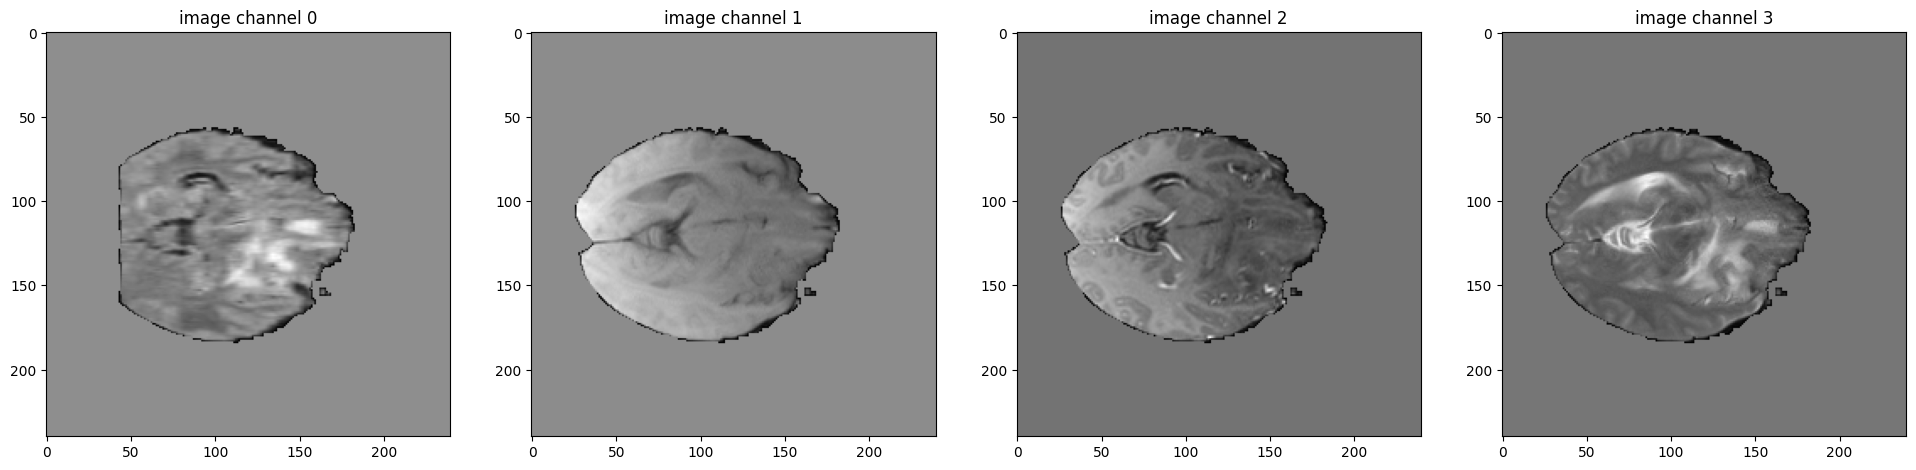

label shape: torch.Size([3, 240, 240, 155])


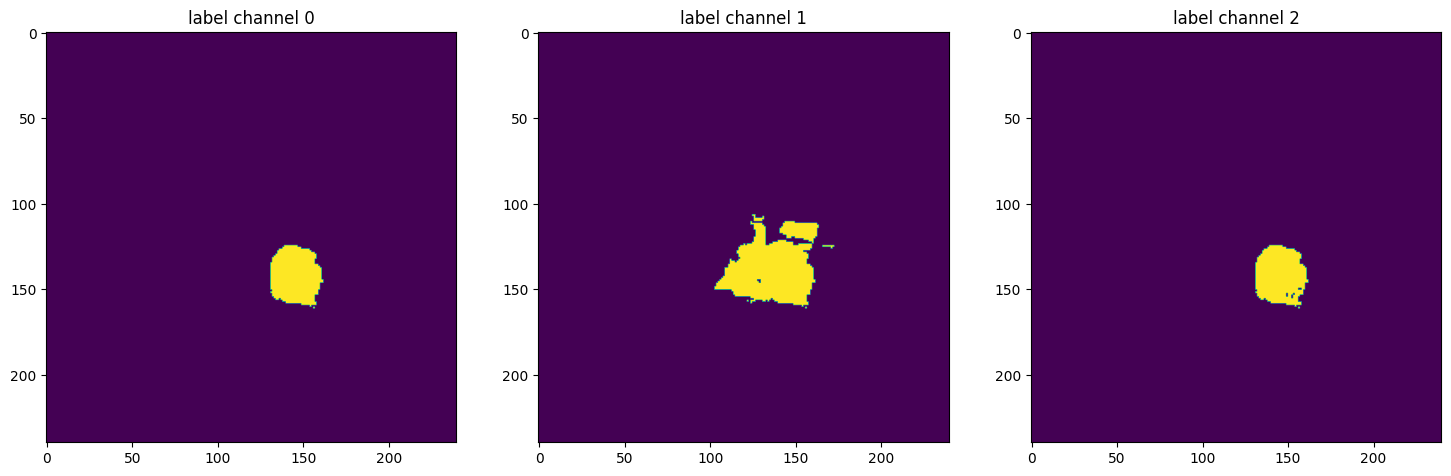

In [20]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_dataset[0]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [21]:
num_epochs = 10

device = torch.device("cuda:0")
# Model definition
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Loss, optimizer, scheduler
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

def inference(input):
    return sliding_window_inference(
        inputs=input,
        roi_size=(240, 240, 160),
        sw_batch_size=1,
        predictor=model,
        overlap=0.5,
    )

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

Training

In [ ]:
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

for epoch in range(num_epochs):
    model.train()
    step = 0
    epoch_loss = 0
    for batch_data in tqdm(train_loader):
        step += 1

        # Load data
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()

        # Perform inference
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    
    lr_scheduler.step()
    epoch_loss /= step
    print(f"epoch {epoch + 1} average dice: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = (
                val_data["image"].to(device),
                val_data["label"].to(device),
            )
            val_outputs = inference(val_inputs)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            dice_metric(y_pred=val_outputs, y=val_labels)
            dice_metric_batch(y_pred=val_outputs, y=val_labels)

        # Dice scores for each region
        metric = dice_metric.aggregate().item()
        metric_values.append(metric)
        metric_batch = dice_metric_batch.aggregate()
        metric_tc = metric_batch[0].item()
        metric_values_tc.append(metric_tc)
        metric_wt = metric_batch[1].item()
        metric_values_wt.append(metric_wt)
        metric_et = metric_batch[2].item()
        metric_values_et.append(metric_et)
        dice_metric.reset()
        dice_metric_batch.reset()

    # Save model checkpoint
    torch.save(
        model.state_dict(),
        f'./checkpoints/epoch{epoch+1}.pth'
    )

Compute Hausdorff Distance over validation set

In [ ]:
model.load_state_dict(torch.load('./checkpoints/epoch10.pth'))
model.eval()

hd_values_tc = 0
hd_values_wt = 0
hd_values_et = 0

for val_data in val_loader:
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    val_outputs = inference(val_inputs)
    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

    hd_values_tc += binary.hd95(val_outputs[0], val_inputs[0])
    hd_values_wt += binary.hd95(val_outputs[1], val_inputs[1])
    hd_values_et += binary.hd95(val_outputs[2], val_inputs[2])

num_val = len(val_loader)
tc = hd_values_et / num_val
wt = hd_values_wt / num_val
et = hd_values_et


print('Hausdorff Distances')
print(F'Tumor Core: {tc:.4f}')
print(F'Whole Tumor: {wt:.4f}')
print(F'Enhancing Tumor: {et:.4f}')

Visualize Results

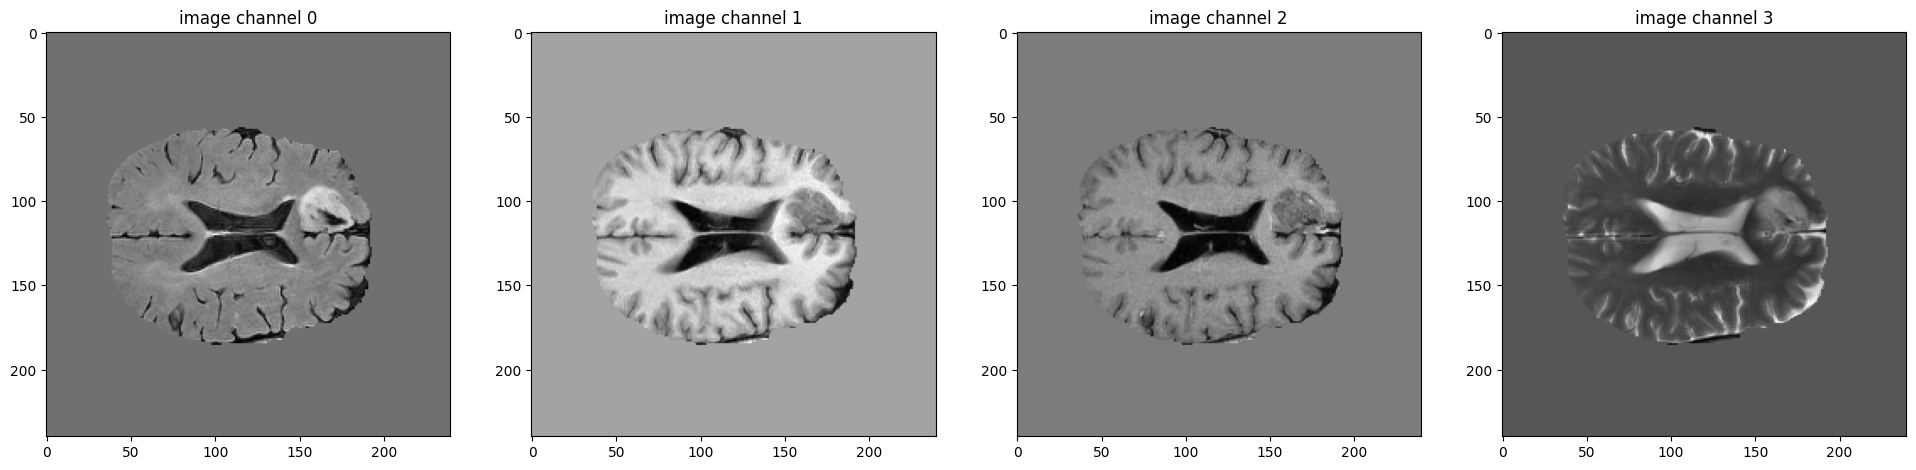

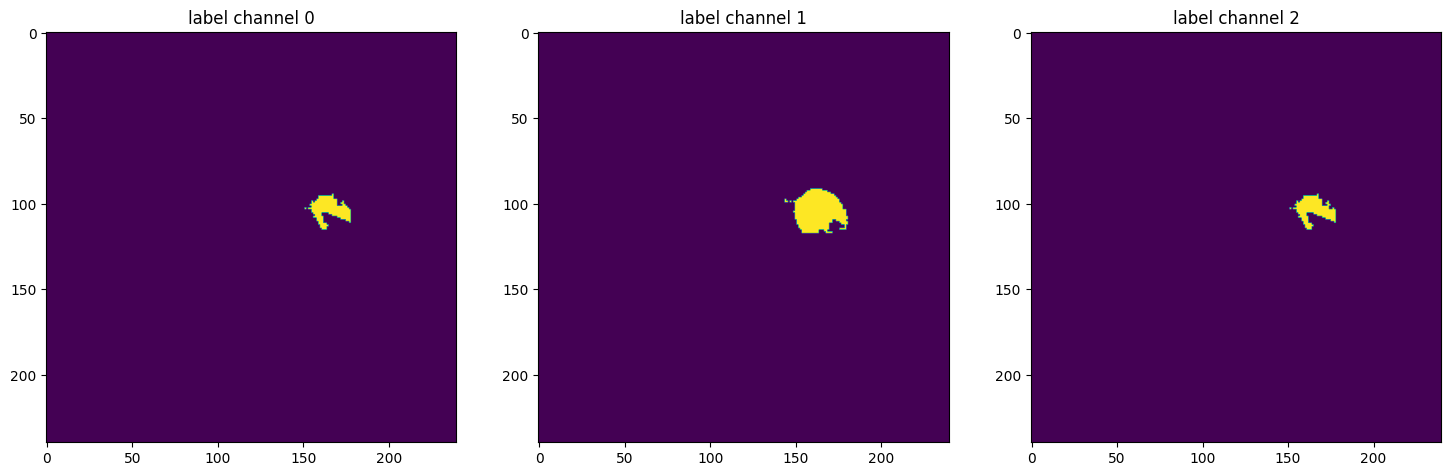

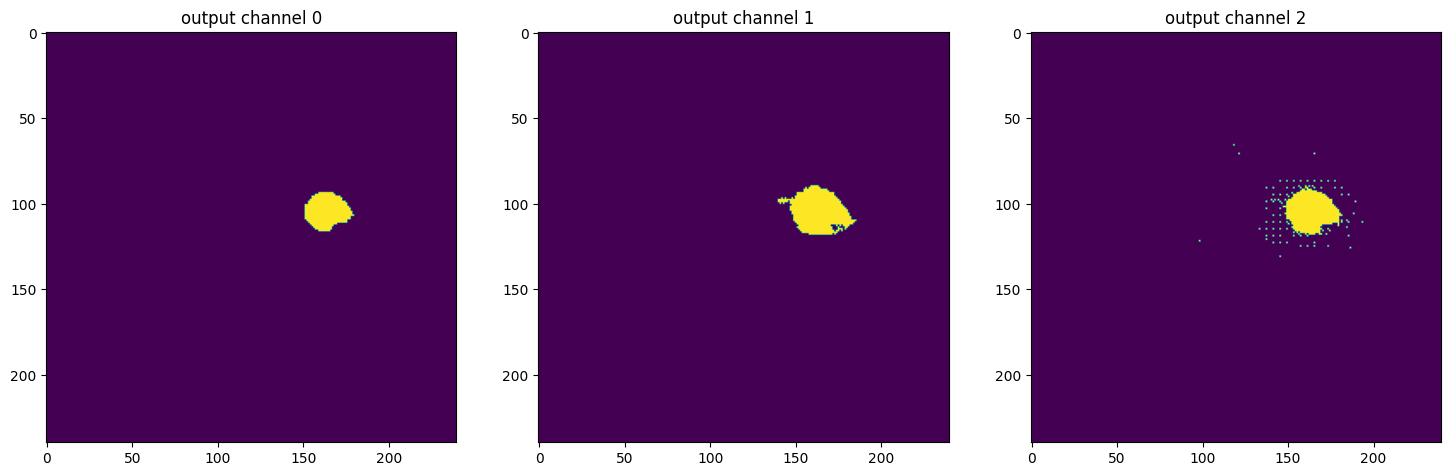

In [28]:
model.eval()
with torch.no_grad():
    # image
    val_input = val_dataset[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_dataset[6]["image"][i, :, :, 80].detach().cpu(), cmap="gray")
    plt.show()
    # labels
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_dataset[6]["label"][i, :, :, 80].detach().cpu())
    plt.show()
    # model output
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 80].detach().cpu())
    plt.show()